### mount google drive

## DATA PREPROCESSING IN RUNTIME

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### copy leaf data to local runtime for faster processing

In [0]:
!rm -rf TrainData/
!mkdir TrainData/
!cp /content/drive/My\ Drive/train_val_split_projc2.zip TrainData/
!unzip -q TrainData/train_val_split_projc2.zip -d TrainData/

### check no of images in training and validation

In [0]:
!ls TrainData/train | wc -l && ls TrainData/val | wc -l

1020
255


### remove train_sep and val_sep folders if they exist

In [0]:
!rm -rf TrainData/train_sep
!rm -rf TrainData/val_sep

### import libraries

In [0]:
import numpy as np
import pandas as pd
import os, random, math, glob, cv2, pickle
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import  train_test_split
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

Using TensorFlow backend.


### make folders for class labels

In [0]:
n_class = 5
class_labels = list(range(n_class))

base_dir = 'TrainData/'

train_input = 'TrainData/train/'
val_input = 'TrainData/val/'

train_save = base_dir+'train_sep/'
val_save = base_dir+'/val_sep/'

if os.path.exists(train_save):
    os.system('rm -rf '+train_save)
if os.path.exists(val_save):
    os.system('rm -rf '+val_save)

os.mkdir(train_save)
os.mkdir(val_save)

# validation
for filenm in glob.glob(val_input+'*.jpg'):
    filename = filenm.split('/')[-1]
    label = filename.split('.')[0].split('_')[-1]

    # print(filename, label)

    dest_dir = val_save+label+'/'
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
    
    # print(dest_dir)
    cmd = 'cp '+filenm+' '+dest_dir+filename
    # print(cmd)
    os.system(cmd)

# train
for filenm in glob.glob(train_input+'*.jpg'):
    filename = filenm.split('/')[-1]
    label = filename.split('.')[0].split('_')[-1]

    # print(filename, label)

    dest_dir = train_save+label+'/'
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
    
    # print(dest_dir)
    cmd = 'cp '+filenm+' '+dest_dir+filename
    # print(cmd)
    os.system(cmd)

### verify if images have been copied properly

In [0]:
!ls TrainData/val_sep/0 | wc -l
!ls TrainData/val_sep/1 | wc -l
!ls TrainData/val_sep/2 | wc -l
!ls TrainData/val_sep/3 | wc -l
!ls TrainData/val_sep/4 | wc -l

!ls TrainData/train_sep/0 | wc -l
!ls TrainData/train_sep/1 | wc -l
!ls TrainData/train_sep/2 | wc -l
!ls TrainData/train_sep/3 | wc -l
!ls TrainData/train_sep/4 | wc -l

51
51
51
51
51
437
278
79
80
146


### determine class weights for imbalanced training

In [0]:
import fnmatch
import numpy as np
from sklearn.utils import class_weight

y=[]
for i in range(5):
    y.extend([i for j in range(len(fnmatch.filter(os.listdir('TrainData/train_sep/'+str(i)), '*.jpg')))])

print(np.bincount(y))

class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weights_dict = dict(zip(range(5), class_weights))
print(class_weights_dict)

[437 278  79  80 146]
{0: 0.4668192219679634, 1: 0.7338129496402878, 2: 2.5822784810126582, 3: 2.55, 4: 1.3972602739726028}


## TRANSFER LEARNING CODE

### delete model h5 files if experiment useless

In [0]:
!rm *.h5

In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2, VGG16, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

### define model based on variable "model_to_use"

In [0]:
model_to_use='resnet50'

base_model=ResNet50(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dense(128,activation='relu')(x)
preds=Dense(5,activation='softmax')(x) 

model=Model(inputs=base_model.input, outputs=preds)

94773248/94765736 [==============================] - 1s 0us/step


### define train and validation generators and images folders

In [0]:
base_dir = 'TrainData/'

train_save = base_dir+'train_sep/'
val_save = base_dir+'/val_sep/'

#train
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=15,
                                    shear_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    brightness_range=(0.1, 0.9),
                                    channel_shift_range=150.0,
                                    horizontal_flip=True)

train_generator=train_datagen.flow_from_directory(train_save, 
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode='categorical',
                                                shuffle=True)
# val
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 

val_generator=val_datagen.flow_from_directory(val_save, 
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode='categorical',
                                                shuffle=False)

Found 1020 images belonging to 5 classes.
Found 255 images belonging to 5 classes.


### train model and save the best validation accuracy checkpoint

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size

earlystop = EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint = ModelCheckpoint('model-epoch-{epoch:03d}-valacc-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')  

no_epochs = 25
hist = model.fit_generator(train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=no_epochs,
                   validation_data=val_generator,
                   validation_steps=step_size_val,
                   callbacks=[earlystop, checkpoint], #callbacks=[checkpoint],
                   class_weight=class_weights_dict)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
63/63 [==============================] - ETA: 0s - loss: 1.5031 - accuracy: 0.3661
Epoch 00001: val_accuracy improved from -inf to 0.48750, saving model to model-epoch-001-valacc-0.487500.h5
63/63 [==============================] - 22s 355ms/step - loss: 1.5031 - accuracy: 0.3661 - val_loss: 1.3337 - val_accuracy: 0.4875
Epoch 2/25
63/63 [==============================] - ETA: 0s - loss: 1.1780 - accuracy: 0.5229
Epoch 00002: val_accuracy improved from 0.48750 to 0.53750, saving model to model-epoch-002-valacc-0.537500.h5
63/63 [==============================] - 22s 346ms/step - loss: 1.1780 - accuracy: 0.5229 - val_loss: 1.0846 - val_accuracy: 0.5375
Epoch 3/25
63/63 [==============================] - ETA: 0s - loss: 1.0976 - accuracy: 0.5508
Epoch 00003: val_accuracy did not improve from 0.53750
63/63 [==============================] - 21s 341ms/step - loss: 1.0976 - accuracy: 0.5508 - val_loss: 1.

### visualize training and validation loss and accuracy

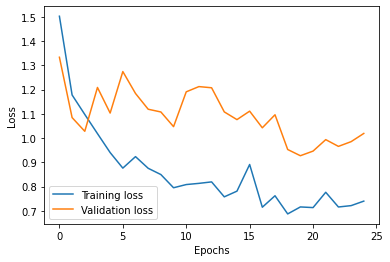

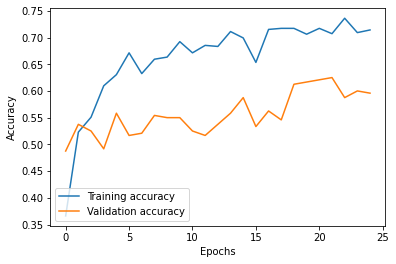

In [0]:
# visualizing losses and accuracy
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_accu = hist.history['accuracy']
val_accu = hist.history['val_accuracy']
xc = range(len(train_loss))

plt.figure()
plt.plot(xc, train_loss, label='Training loss')
plt.plot(xc, val_loss, label='Validation loss')
plt.legend(loc="lower left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('train_val_loss.png')
plt.show()

plt.figure()
plt.plot(xc, train_accu, label='Training accuracy')
plt.plot(xc, val_accu, label='Validation accuracy')
plt.legend(loc="lower left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('train_val_accuracy.png')
plt.show()

## VALIDATE MODEL

### load model with best validation accuracy

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

model_path = '/content/drive/My Drive/Models_Resnet/classweight/Best_model/model-epoch-024-valacc-0.625000.h5'
model.load_weights(model_path)

### model predict on validation data 

In [0]:
val_generator.reset()
val_steps = np.math.ceil(val_generator.samples/val_generator.batch_size)
ypred = model.predict_generator(val_generator, steps=len(val_generator))

print(ypred.shape)

(255, 5)


### final class labels for validation images

In [0]:
ypred_labels = np.argmax(ypred, axis=1)
np.bincount(ypred_labels)

array([73, 24, 40, 69, 49])

### compute confusion matrix, accuracy score and display classification report

In [0]:
ytrue = []
for filenm in val_generator.filenames:
    ytrue.append(int(filenm.split('/')[0]))

In [0]:
confusion_matrix(ytrue, ypred_labels)

array([[43,  5,  1,  2,  0],
       [26, 17,  7,  1,  0],
       [ 4,  2, 24, 20,  1],
       [ 0,  0,  8, 38,  5],
       [ 0,  0,  0,  8, 43]])

In [0]:
accuracy_score(ytrue, ypred_labels)

0.6470588235294118

In [0]:
print(classification_report(ytrue, ypred_labels))

              precision    recall  f1-score   support

           0       0.59      0.84      0.69        51
           1       0.71      0.33      0.45        51
           2       0.60      0.47      0.53        51
           3       0.55      0.75      0.63        51
           4       0.88      0.84      0.86        51

    accuracy                           0.65       255
   macro avg       0.67      0.65      0.63       255
weighted avg       0.67      0.65      0.63       255



## TEST MODEL

### bring test data into runtime

In [0]:
!mkdir TestData/
!cp -r /content/drive/My\ Drive/ECE542_sp20_CompetitionData/TestData TestData/

### import libraries

In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2, VGG16, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import load_model

### define model and load weights

In [0]:
base_model=ResNet50(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dense(128,activation='relu')(x)
preds=Dense(5,activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=preds)

model_path = '/content/drive/My Drive/Models_Resnet/classweight/Best_model/model-epoch-024-valacc-0.625000.h5'
model.load_weights(model_path)

### define test generator

In [0]:
test_save = 'TestData/'

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator=test_datagen.flow_from_directory(test_save, 
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode=None,
                                                shuffle=False)

Found 200 images belonging to 1 classes.


### check if generator filenames arrives in sorted order of filenames

In [0]:
non_sorted = test_generator.filenames
sorted_list = sorted(non_sorted)

sorted_list == non_sorted

True

### predict labels for test data and save predictions as CSV file

In [0]:
from keras.utils import to_categorical

ypred = model.predict_generator(test_generator, steps=len(test_generator))
ypred_labels = np.argmax(ypred, axis=1)
ypred_onehot = to_categorical(ypred_labels, num_classes=5)

print(ypred.shape)
print(np.bincount(ypred_labels))
# np.savetxt('predictions_model-epoch-024-valacc-0.625000.csv', ypred_onehot, fmt='%d', delimiter=',')
print('Predictions onehot file saved!')

(200, 5)
[36 72 16 21 55]
Predictions onehot file saved!
